In [9]:
import numpy as np
import random
import copy
import globals as gb
from icecream import ic
from tqdm.auto import tqdm
from dataclasses import dataclass
from tree import Tree, swap_subtrees, generate_initial_solution
from utils import mse, sort_individuals, are_compatible
from mutations import mutation
from tree_node import TreeNode

## Problem selection

In [10]:
gb.initialize_globals_for_problem(0)

POPULATION_SIZE = gb.PROBLEM_SIZE * 20
OFFSPRING_SIZE = int(POPULATION_SIZE / 4)
# MAX_ITERATIONS = POPULATION_SIZE * 50
MAX_ITERATIONS = 5000


## Steps
- We treat a possible solution as a tree. The tree has attribute root, which is the root of the tree of class TreeNode and max_depth.
- Generate random tree
    - we need each variable at least once 
    - each variable has exactly one coefficient chosen as a random float number in the range [?, ?]
    - each variable has exactly one unary operator
    - unary operator is chosen as: 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among all other unary operators
        - check if the unary operator is appliable to the variable ->
            ```
            leaves_map = {}
            for e in leaves:
                available_unary_operators = [op for op in list(UNARY_OPERATORS.keys()) if op.is_applicable(e)]
                chosen_unary_operator = 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among [available_unary_operators]
                leaves_map[e] = [chosen_unary_operator]
            # leaves = [-2, 3]
            # leaves_map = {-2: square, 3: log}
            for e in leaves:
                node = leaves_map[e]
                node.left = null
                node.right = e
                # insert node to tree
            ```
    - number of leaves = nearest power of two greater than keys.length()
    - number of actual leaves = [number of leaves] * 2
    - number of coefficients = [number of leaves] - keys.length()
    - number of binrary operators = total number of nodes in  tree with [number of leaves] leaves - [number of leaves]]
    - validate tree
    - if valid, return tree
    - else, ?
- Example:
    - x.length() = 3
    - number of leaves = 4
    - number of actual leaves = 8
    - number of coefficients = 1
    - number of operands = 3

    ```bash
                    +
            /                  \
            *                    +
        /      \           /        \
      u        1          1          u
    /   \    /   \      /   \       /  \
    nul  *  nul   *    nul    *     nul *
    ```
### EA approach
- Individual is rapresented as a tree and a fitness
    - fitness is a tuple of 2 values: (-mse, right_sign_100)
        - right_sign_100 is the percentage of correct sign predictions
        - mse is the mean squared error
- Classic Genetic Programming
    - Key elements 
    - Representation: tree structures
    - Recombination: exchange of subtrees
    - Mutation: random change in trees
        - subtree mutation -> replace  entire subtree
        - point  mutation -> change single node
        - permutation -> exchange node right with left
        - hoist -> take subtree and make it root
        - expansion -> take random leaf and replace it with a new subtree
        - collapse -> take a subtree and replace it with leaf
    - Population model: generational
    - Parent selection: fitness proportional
    - Survivor selection: deterministic

##next

    - finish implementing mutations
    - find way to reduce tree dimension
    - add weights to opertors
    - add check if fitness doesn't improve , stop early
    - 

##problems
    - overflow
    - initial tree with 4xnodes has invalid values
    - 


## Individual definition

In [11]:
@dataclass
class Individual:
    genome: Tree
    fitness: tuple

## Fitness evaluation

In [12]:
def fitness(sol: Tree):
    y_computed = sol.root.evaluate_tree_from_node()
    right_sign_100 = 100 * np.sum(np.sign(y_computed) == np.sign(gb.Y)) / len(gb.Y)
    n_expected_leaves = int(2 ** np.ceil(np.log2(gb.PROBLEM_SIZE)))
    expected_depth = np.log2(n_expected_leaves * 2) + 1
    depth_penalty = (np.exp((sol.get_max_depth() / expected_depth)) - 1) if sol.get_max_depth() > expected_depth else 0
    # smoothness_penalty = np.mean(np.abs(np.diff(y_computed)))
    
    leaves = [node.value for node in sol.get_leaves_nodes()]
    missing_variables = [x for x in list(gb.VARIABLES_MAP.keys()) if x not in leaves]
    missing_variables_penalty = (np.exp((len(missing_variables) / len(list(gb.VARIABLES_MAP.keys())))) - 1) if len(missing_variables) > len(list(gb.VARIABLES_MAP.keys())) else 0

    return  -mse(y_computed, gb.Y) * (1 + depth_penalty + missing_variables_penalty), right_sign_100

## EA helper functions

In [16]:
def parent_selection(population: list[Individual], scores, worst_score):
    # windowing    
    scores_prime = [(s-worst_score) for s in scores]
    # print(len(population), len(scores))
    total = sum(scores_prime)
    # if all population doesn't have some score
    if total != 0:
        probabilities = [s/total for s in scores_prime]

        parents = random.choices(population, probabilities, k=2)
            
        return parents[0], parents[1]
    
    return population[0], population[1]

def xover(parent1, parent2)-> tuple[Tree, tuple]:
    # parents = random.choices(population, k=2)

    # reproduce
    c1 = copy.deepcopy(parent1.genome)
    c2 = copy.deepcopy(parent2.genome)

    success = swap_subtrees(c1, c2)

    c_fitness = fitness(c2)

    if not success:
        # mutation
        mutation(c2)

    return c2, c_fitness

def tournament(population):
    # generate a certain number of tournaments
    n_tour = POPULATION_SIZE // 5
    winners = []
    # for each tournament find a winner for a portion of the population
    for i in range(n_tour):
        start =int( i*len(population)/n_tour)
        end =int( (i+1)*len(population)/ n_tour)
        p_i = population[start : end]
 
        w_i = ea(p_i, 50,disable_print=True)
        winners.append(w_i)
    winners , scores = sort_individuals(winners)
   
    # get the best winner/s
    # check if there are pari merito
    best_score = np.max(scores)
    return [winners[i] for i in range(len(winners)) if scores[i]==best_score]
    return winners

def fine_tuning(best: Individual):
    genome = best.genome
    best_fitness = best.fitness

    n_no_inc = 0

    leaves = genome.get_leaves_nodes()

    max_iterations = MAX_ITERATIONS // 10
    for i in range(max_iterations):
        leaf = np.random.choice(leaves)
        new_f = tune_constant(leaf,genome, best_fitness)

        if new_f > best_fitness:
            best_fitness = new_f
            n_no_inc = 0
        else:
            n_no_inc += 1

        if i % 5000 == 0 and i != 0:
            print(best_fitness)

        if n_no_inc > 1000:
            print("Early stopping")
            break

    # print("New best fitness:", best_fitness)
    # genome.draw_tree()
    best.fitness = best_fitness


def tune_constant(node: TreeNode, curr_genome, curr_fitness):
    mutation_factor = 1.002
    improve = True
    direction_changed = False
    while improve:
        if node.value in gb.VARIABLES_MAP:
            node.coefficient *= mutation_factor  # Modify costant
            if round(node.coefficient)!=0: 
                node.coefficient = round(node.coefficient,4)
        else:
            node.value *= mutation_factor
            if round(node.value)!=0: 
                node.value = round(node.value,4)
                
        new_mse, right_sign = fitness(curr_genome)
        new_fitness = ( new_mse, right_sign)
        # Aggiorna la soluzione migliore
        if new_fitness > curr_fitness:
            curr_fitness = new_fitness
            mutation_factor/=mutation_factor
        else:
            if node.value in gb.VARIABLES_MAP:
                node.coefficient /= mutation_factor  # Revert change
            else:
                node.value /= mutation_factor
            if not direction_changed:
                direction_changed = True
                mutation_factor = 0.998 # try to explore backward
            else: 
                improve = False
    
    return curr_fitness    


def ea(population, iterations=200, best=None, best_score=-1, disable_print=False):
    # print(population)
    scores = []
    offsprings = []
    worst_score = 0


    # Initialize stopping condition for maximization problem
    min_iterations = POPULATION_SIZE  # Wait for at least one generation
    patience = int(iterations / 5)  # Wait for half a generation worth of iterations
    stagnation_counter = 0
  


    for ind in population:
        ind.fitness = fitness(ind.genome)
    population, scores = sort_individuals(population)

    for i in tqdm(range(iterations), disable=disable_print):
    
        for _ in range(OFFSPRING_SIZE):
            parent1, parent2 = parent_selection(population, scores, worst_score)
            # crossover
            if random.random() < 0.7:
                child, c_fitness = xover(parent1, parent2)
        
                offsprings.append(Individual(child, c_fitness))

            # mutation
            else :
                # take a random individual and mutate it
                ind = copy.deepcopy(random.choice([parent1,parent2]))

                mutation(ind.genome)
                # recompute fitness
                ind.fitness = fitness(ind.genome)
                offsprings.append(ind)

        population.extend(offsprings)
        offsprings = []
        
        # sort population according to score based on fitness         
        population, scores = sort_individuals(population)
        
        score = scores[0] # best sscore in currrent population

        
        if i % patience == 0 and i > min_iterations:
            print(f"iteration {i} mse {mse(population[0].genome.root.evaluate_tree_from_node(), gb.Y)}")
            if score > best_score*(1.01):
                #print(f"new best score : {score}, old score : {best_score}")
                best = population[0]
                best_score = score
                stagnation_counter = 0
            elif score <= best_score*1.01 and score >= best_score*0.99:
                stagnation_counter+=1
                if stagnation_counter == 3:
                    print("STOP")
                    break
            # put again the best one in population
            else: 
                #print("valhalla")
                population.append(best)
                population,scores = sort_individuals(population)
                # print(f"valhallla {i}: scores {scores}\n")ù
                stagnation_counter = 0

        # remove worst individual
        population = population[:POPULATION_SIZE]
        scores = scores[:POPULATION_SIZE]

        worst_score = scores[OFFSPRING_SIZE-1] # if worst_score > scores[-1] else worst_score


    print(f"winner's mse {mse(population[0].genome.root.evaluate_tree_from_node(), gb.Y)} score: {scores[0]}")

    
    return population[0]

## Main

winner's mse 74.3883127662365 score: 0.9928
winner's mse 20.990756837825046 score: 0.9928
winner's mse 32.29978808747603 score: 0.9928
winner's mse 74.02848207331617 score: 0.9927536971079156
winner's mse 42.717901522044144 score: 0.9612
winner's mse 42.86161634241164 score: 0.9928
winner's mse 82.53923484950495 score: 0.9928
winner's mse 33.9688292836647 score: 0.9928
winner's mse 54.07254202418801 score: 0.9928
winner's mse 62.05057243072216 score: 0.9928
winner's mse 55.3602056626816 score: 0.9928
winner's mse 71.13714137802563 score: 0.9928
winner's mse 156.83661965953874 score: 0.9928
winner's mse 61.39940636632618 score: 0.9928
winner's mse 48.606659344146884 score: 0.9928
winner's mse 8.605482956132635 score: 0.9928
winner's mse 65.42592369254491 score: 0.9932
winner's mse 74.85164055849607 score: 0.9932819884811507
winner's mse 17.800683573319144 score: 0.9928
winner's mse 1.0958569529800453 score: 0.9928
winner's mse 61.3940110369374 score: 0.9928
winner's mse 3.68964158645975

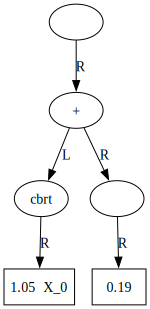

Best individual mse 68.05950716472728


  0%|          | 0/5000 [00:00<?, ?it/s]

iteration 1000 mse 1.0958569529800453
iteration 2000 mse 1.0958569529800453
iteration 3000 mse 1.0958569529800453
STOP
winner's mse 1.0958569529800453 score: 0.9928
Best individual has formula:
 (0.990871492491778 X_0 ) = y
Best individual mse 1.0958569529800453


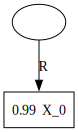

tuning...
Best individual has formula:
Best individual mse 1.0678362639207222
Best individual has formula:
 (1.0009018036072144 X_0 ) = y


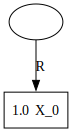

In [14]:
# state = random.getstate()
# population = [Individual(generate_initial_solution(seed=(i+2) * 10), 0) for i in range(POPULATION_SIZE)]
population = [Individual(generate_initial_solution(), 0) for i in range(POPULATION_SIZE)]

offsprings = []
# random.setstate(state)

# torunament -> use initial population
winners = tournament(population)

#generate population from winner/s
population = []
for w in winners:
    for i in range(int(POPULATION_SIZE/len(winners))-1):
        ind = copy.deepcopy(w)

        mutation(ind.genome)
        # recompute fitness
        ind.fitness = fitness(ind.genome) 
        population.append(ind)
    population.append(w)


population, scores = sort_individuals(population)
population[0].genome.draw_tree()

print(f"Best individual mse {mse(population[0].genome.root.evaluate_tree_from_node(), gb.Y)}")
# ea
result = ea(population, MAX_ITERATIONS, population[0], scores[0])
print("Best individual has formula:")
result.genome.print_tree()
print(f"Best individual mse {mse(result.genome.root.evaluate_tree_from_node(), gb.Y)}")
result.genome.draw_tree() 
print("tuning...")
# fine tuning of constants
fine_tuning(result)

print("Best individual has formula:")
print(f"Best individual mse {mse(result.genome.root.evaluate_tree_from_node(), gb.Y)}")
print("Best individual has formula:")
result.genome.print_tree()
result.genome.draw_tree() 


In [15]:
x = gb.X
res = np.multiply(np.add(np.multiply(np.add(x[0], np.add(x[1], x[1])), np.cos(np.sqrt(np.abs(np.add(x[0], x[2]))))), np.add(np.multiply(np.add(x[2], x[1]), np.divide(np.sin(x[0]), np.add(x[0],1e-20))), np.multiply(np.add(np.sin(x[0]), x[0]), 2))), 700000)
print(mse(res,gb.Y))

IndexError: index 2 is out of bounds for axis 0 with size 2

In [20]:
print(f"{np.mean(gb.Y - gb.X[0])}")
print(f"{np.mean(gb.Y -(gb.X[0]+ gb.X[1]/5))}")


21.201435091724733
21.214446497086826


In [21]:
x0 = gb.X[0]
x1 = gb.X[1]
res = ((x0 + -1.4220549) * (x1 / (1.1754677 / x1))) * ((x0 * ((x1 - 2.3935468) * -3.7704857e-12)) * x0)
mse(res,gb.Y)

np.float64(301129.62907841674)

## version 2

In [22]:
""" POPULATION_SIZE = PROBLEM_SIZE*20
OFFSPRING_SIZE = POPULATION_SIZE*3
MAX_ITERATIONS = 1000 """

' POPULATION_SIZE = PROBLEM_SIZE*20\nOFFSPRING_SIZE = POPULATION_SIZE*3\nMAX_ITERATIONS = 1000 '

In [ ]:
""" state = random.getstate()
initial_population = [Individual(generate_initial_solution(seed=(i+2) * 10), 0) for i in range(POPULATION_SIZE)]
offsprings = []
random.setstate(state)

# set the fitness
for ind in initial_population:
    ind.fitness = fitness(ind.genome)
initial_population, scores = sort_individuals(initial_population)
initial_population[0].genome.draw_tree()

# print(initial_population)

best = None
best_score = 0
worst_score = 0
scores = [compute_score(initial_population[i], initial_population) for i in range(POPULATION_SIZE)]

for i in tqdm(range(MAX_ITERATIONS)):
# for i in range(MAX_ITERATIONS):
    for _ in range(OFFSPRING_SIZE):
        parent1, parent2 = parent_selection(initial_population, scores, worst_score)
        # crossover
        if random.random() < 0.65:
            child, c_fitness = xover(parent1, parent2)
    
            offsprings.append(Individual(child, c_fitness))

        # mutation
        else :
            # take a random individual and mutate it
            ind = copy.deepcopy(random.choice([parent1,parent2]))

            mutation(ind.genome)
            # recompute fitness
            ind.fitness = fitness(ind.genome)
            offsprings.append(ind)

    
    # sort population according to score based on fitness         
    initial_population, scores = sort_individuals(offsprings)
    # print(f"{i}: scores {scores}\n")

    if i % 100 == 0:
        print(f"iteration {i} best individual : {initial_population[0].fitness}")
        # compute score 
        score = scores[0]
        if score > best_score:
            print(f"new best score : {score}, old score : {best_score}")
            best = initial_population[0]
            best_score = score

        # put again the best one in population
        else: 
            print("valhalla")
            initial_population.append(best)
            initial_population,scores = sort_individuals(initial_population)
            print(f"valhallla {i}: scores {scores}\n")

        worst_score = scores[OFFSPRING_SIZE-1] # if worst_score > scores[-1] else worst_score
   
   
    # remove worst individual
    initial_population = initial_population[:POPULATION_SIZE]
    scores = scores[:POPULATION_SIZE]
    # print(f"cut {i}: scores {scores}\n")
 
    # update the worst score
    # print(f"iteration {i} ")
    offsprings = []

print("Best individual has formula:")
print(f"Best individual mse {mse(initial_population[0].genome.root.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), y)}")
initial_population[0].genome.draw_tree() """

' state = random.getstate()\ninitial_population = [Individual(generate_initial_solution(seed=(i+2) * 10), 0) for i in range(POPULATION_SIZE)]\noffsprings = []\nrandom.setstate(state)\n\n# set the fitness\nfor ind in initial_population:\n    ind.fitness = fitness(ind.genome)\ninitial_population, scores = sort_individuals(initial_population)\ninitial_population[0].genome.draw_tree()\n\n# print(initial_population)\n\nbest = None\nbest_score = 0\nworst_score = 0\nscores = [compute_score(initial_population[i], initial_population) for i in range(POPULATION_SIZE)]\n\nfor i in tqdm(range(MAX_ITERATIONS)):\n# for i in range(MAX_ITERATIONS):\n    for _ in range(OFFSPRING_SIZE):\n        parent1, parent2 = parent_selection(initial_population, scores, worst_score)\n        # crossover\n        if random.random() < 0.65:\n            child, c_fitness = xover(parent1, parent2)\n    \n            offsprings.append(Individual(child, c_fitness))\n\n        # mutation\n        else :\n            # take